# Aggregation queries

In this assigment, we will fetch data from a relational database server directly into Python variables. Using these new skills, we will complete the problems from Chapters 12, 13, and 14 in *SQL Queries for Mere Mortals*.

## Concepts

Review the MySQL aggregate functions: https://dev.mysql.com/doc/refman/8.0/en/aggregate-functions.html

Three types of queries

1. Aggregation functions with no `GROUP BY` clause produce 1 row. 
2. Aggregation functions combined with a `GROUP BY` clause. The unique key of the result is composed of the columns of the `GROUP BY` clause.
3. Most common pattern: `JOIN` or `LEFT JOIN` of a table pair in a one-to-many relationship, grouped by the primary key of the left table. This aggregates the right entity set with respect to the left entity set. 

Note that MySQL with the default settings allows mixing aggregated and non-aggregated values (See https://dev.mysql.com/doc/refman/5.7/en/sql-mode.html#sqlmode_only_full_group_by). So you have to watch avoid invalid mixes of values.

Using `HAVING` is equivalent to using a `WHERE` clause in an outer query.

# Aggregation Queries

Queries using aggregation functions, `GROUP BY`, and `HAVING` clauses. Using `LEFT JOIN` in combination with `GROUP BY`

In [1]:
import json
import pymysql 

pymysql.install_as_MySQLdb()

with open('cred.json') as f:
    creds = json.load(f)

connection_string = "mysql://{user}:{password}@{host}".format(**creds)

%load_ext sql
%config SqlMagic.autocommit=True
%sql $connection_string

[2022-11-01 18:34:02,978][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-11-01 18:34:03,305][INFO]: Connected dimitri@db.ust-data-sci.net:3306


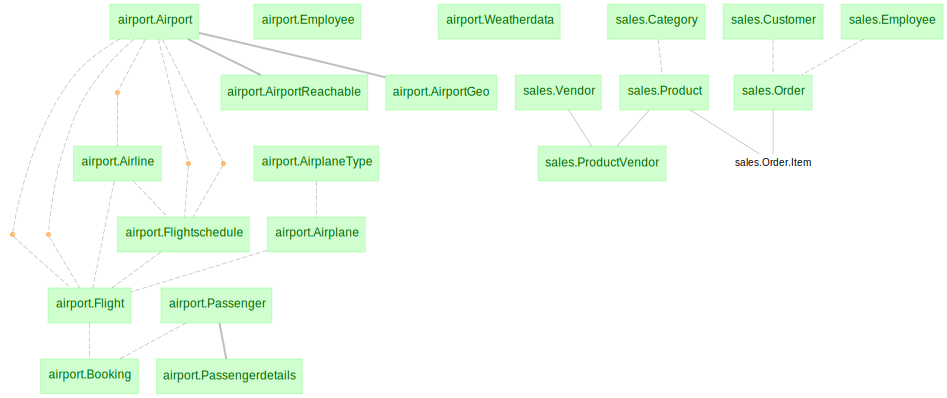

In [2]:
import datajoint as dj
sales = dj.create_virtual_module('sales', 'shared_sales')
airport = dj.create_virtual_module('airport', 'shared_airport')
dj.Diagram(sales) + dj.Diagram(airport)

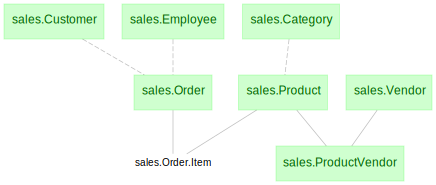

In [3]:
dj.Diagram(sales)

In [4]:
sales.ProductVendor()

product_number,vendor_id,wholesale_price,days_to_deliver
1,4,804.00,6
1,9,854.22,7
2,6,1269.00,9
2,9,1477.81,7
3,7,54.19,10
3,9,57.27,6
4,6,44.22,10
4,9,41.62,14
5,7,5.38,10
5,9,5.87,9


### Increasing complexity of queries

In [ ]:
%%sql

USE shared_sales

## Aggregation functions MAX, MIN, AVG, SUM, COUNT

In [ ]:
%%sql

SELECT *
FROM product 
LIMIT 10;

In [ ]:
%%sql
-- show the max retail price and the average retail price of products

SELECT COUNT(*) AS n, MAX(retail_price) max_price, 
    AVG(retail_price) avg_price 
FROM product

In [ ]:
%%sql

SELECT count(*) n,
MAX(retail_price) max_price, 
AVG(retail_price) avg_price 
FROM product

In [ ]:
%%sql

-- aggregation with condition
-- show the average retail price for non-bikes

SELECT AVG(retail_price) as avg_price 
FROM product 
WHERE category_id NOT IN (
    SELECT category_id 
    FROM category
    WHERE category_description = "Bikes")

In [ ]:
%%sql
-- show products above average price
-- The following does NOT work

SELECT * 
FROM product 
WHERE retail_price > avg(retail_price)

In [ ]:
%%sql
-- show products above average price
-- Use a scalar subquery

SELECT * 
FROM product 
WHERE retail_price > (SELECT avg(retail_price) FROM product)

In [ ]:
%%sql

-- what not to do:

SELECT *
FROM product
GROUP BY category_id


In [ ]:
%%sql

-- this is good

SELECT category_id
FROM product
GROUP BY category_id


In [ ]:
%%sql

SELECT DISTINCT category_id
FROM product

In [ ]:
%%sql
-- show the numbers and average price of products in each category

SELECT category_id, 
   count(*) as n, 
   ROUND(AVG(retail_price), 2) as avg_price
FROM  product
GROUP BY category_id


In [ ]:
%%sql 

-- using in a subquery

SELECT * FROM (
    SELECT category_id, round(AVG(retail_price), 2) as avg_price
    FROM product
    GROUP BY category_id) as _ NATURAL JOIN category


In [ ]:
%%sql 

-- pre-join before group

SELECT category.*, avg(retail_price) as avg_price 
FROM category NATURAL LEFT JOIN product
GROUP BY category_id

In [ ]:
%%sql

-- show number of products in each  category with retail price > 100.00

SELECT category.*, count(*) as n
FROM category NATURAL JOIN product 
WHERE retail_price > 100
GROUP BY category_id

In [ ]:
%%sql 
-- show the number of items in each category priced over $100
SELECT category.*, count(product_number) as number_of_products
FROM category NATURAL LEFT JOIN (
    SELECT * FROM product WHERE retail_price > 100) as _
GROUP BY category_id


In [ ]:
%%sql

-- show the top 10 customers who placed most orders

SELECT customer_id, count(order_number) as number_of_orders
FROM customer NATURAL LEFT JOIN `order` 
GROUP BY customer_id
ORDER BY number_of_orders DESC
LIMIT 10

In [ ]:
%%sql

-- show all customers who have placed over 40 orders since 
-- the start of 2016

SELECT * FROM (
    SELECT customer_id, count(order_number) as number_of_orders
    FROM customer NATURAL JOIN `order` 
    WHERE order_date > "2016-01-01"
    GROUP BY customer_id) as _
WHERE number_of_orders > 40

In [ ]:
%%sql

-- show all customers who have placed over 40 orders 
-- since the start of 2016

SELECT customer_id, count(order_number) as number_of_orders
FROM customer NATURAL LEFT JOIN `order` 
WHERE order_date > "2016-01-01"
GROUP BY customer_id
HAVING number_of_orders > 40
ORDER BY number_of_orders DESC

In [ ]:
%%sql

-- show the customer who has spent the most money

SELECT customer.*, sum(quoted_price * quantity_ordered) as total
FROM customer NATURAL LEFT JOIN 
   (SELECT * FROM `order` NATURAL JOIN `order__item`) as _
GROUP BY customer_id
ORDER BY total DESC
LIMIT 1


In [ ]:
%%sql

SELECT customer.*, sum(quoted_price * quantity_ordered) as total
FROM customer NATURAL JOIN `order` NATURAL JOIN `order__item`
GROUP BY customer_id
ORDER BY total DESC
LIMIT 1

In [ ]:
%%sql

-- show averages prices per category for products with 
-- retail price > 100.00

SELECT category.*, round(AVG(retail_price), 2) as avg_price 
FROM category NATURAL JOIN product
WHERE retail_price > 100
GROUP BY category_id

In [ ]:
%%sql

-- Categories with the average prices > 100

SELECT * FROM (
    SELECT category.*, AVG(retail_price) as avg_price 
    FROM category NATURAL JOIN product
    GROUP BY category_id) as q
WHERE avg_price > 100

In [ ]:
%%sql

-- Categories with the average prices > 100

SELECT category.*, AVG(retail_price) as avg_price 
FROM category NATURAL JOIN product
GROUP BY category_id
HAVING avg_price > 100


In [ ]:
%%sql
-- show empty orders 

SELECT * 
FROM `order` 
WHERE order_number NOT IN (
    SELECT order_number 
    FROM order__item)

In [ ]:
%%sql
-- show empty orders

SELECT * 
FROM `order` NATURAL LEFT JOIN order__item
WHERE product_number is NULL

In [ ]:
%%sql

-- bad because mixes aggregated and random 

SELECT * FROM `order`  NATURAL LEFT JOIN order__item
GROUP BY order_number
LIMIT 10

In [ ]:
%%sql

-- show empty orders

SELECT `order`.*, COUNT(product_number) as nitems 
FROM `order` NATURAL LEFT JOIN order__item
GROUP BY order_number
HAVING nitems = 0

In [ ]:
%%sql

SELECT `order`.*, product_number as nitems 
FROM `order`  NATURAL LEFT JOIN order__item
LIMIT 10

## Example problems

In [ ]:
%%sql

-- Customers and the number of orders that they made

SELECT customer_id, customer_first_name, customer_last_name, 
  count(order_number) as norders
FROM customer NATURAL LEFT JOIN `order`
GROUP BY customer_id
ORDER BY norders DESC
LIMIT 10

In [ ]:
%%sql

-- orders with their total amounts

SELECT `order`.*, IFNULL(sum(quoted_price * quantity_ordered), 0) as total_amount
FROM `order` NATURAL LEFT JOIN `order__item` 
GROUP BY order_number
ORDER BY total_amount 
LIMIT 10

In [ ]:
%%sql

-- customers and the total $$$ spent

SELECT customer_id, customer_last_name, sum(total_amount) money_spent
FROM customer NATURAL LEFT JOIN (
    SELECT `order`.*, IFNULL(sum(quoted_price * quantity_ordered), 0) as total_amount
    FROM `order` NATURAL LEFT JOIN `order__item` 
    GROUP BY order_number) as q
GROUP BY customer_id
ORDER BY money_spent DESC
LIMIT 10


In [ ]:
%%sql

-- customers and the total $$$ spent

SELECT customer_id, customer_last_name, 
   IFNULL(sum(quoted_price * quantity_ordered), 0) money_spent
FROM customer NATURAL LEFT JOIN `order` NATURAL JOIN `order__item`
GROUP BY customer_id
ORDER BY money_spent DESC
LIMIT 10

# Summary of principles 
1. Without a `GROUP BY`, aggregation functions collapse the table into a single row.
2. With `GROUP BY`, the grouping attributes become the new primary key of the result.  
3. Do not mix aggregated and non-aggregated values in the result with or without a `GROUP BY`.
4. `HAVING` plays the same role as the `WHERE` clause in a nesting outer query so it can use the output of the aggregation functions.
5. `LEFT JOIN` is often follwed with a `GROUP BY` by the primary key attributes of the left table. In this scenario the entities in the right table are aggregated for each matching row in the left table.


### Chapter 12 (total aggregation -- no grouping)


Problem 1. 
“How many customers do we have in the state of California?”

Viescas, John L.. SQL Queries for Mere Mortals (p. 460). Pearson Education. Kindle Edition. 

In [ ]:
dj.U().aggr(sales.Customer() & 'customer_state="CA"', n='count(*)')

In [ ]:
%%sql

SELECT count(*) as n FROM customer WHERE customer_state="CA"

“What is the average retail price of a mountain bike?” 

Viescas, John L.. SQL Queries for Mere Mortals (p. 467). Pearson Education. Kindle Edition. 

In [ ]:
“What was the date of our most recent order?”

Viescas, John L.. SQL Queries for Mere Mortals (p. 467). Pearson Education. Kindle Edition. 

In [ ]:
%%sql 
SELECT order_number, order_date as latest_order
FROM `order`
ORDER BY latest_order DESC
LIMIT 1

In [ ]:
%%sql
SELECT max(order_date) as last_date 
FROM `order`

In [ ]:
%%sql
-- When was the last order to a customer in California

SELECT max(order_date) as last_date
FROM `order`
WHERE customer_id in 
(SELECT customer_id FROM customer WHERE customer_state="WA")

In [ ]:
%%sql 
SELECT max(order_date) as last_date
FROM `order` NATURAL JOIN customer
WHERE customer_state="WA"

In [ ]:
dj.U().aggr(sales.Order * sales.Customer & 'customer_state="WA"', 
            last_date='max(order_date)')

### Chapter 13 (aggregation with grouping)

In [ ]:
“Display for each product the product name and the total sales.”

Viescas, John L.. SQL Queries for Mere Mortals (p. 490). Pearson Education. Kindle Edition. 

# Homework --- Due Nov 12

## Chapter 12

**Problem 1 (Sales):** Show the total amount of order number 8.
    
    Answer $1492.60

## Chapter 13

**Problem 3 (Sales):** List vendors along with the average number of days they take to deliver the order.
    
    Answer 10 rows.

**Problem 4 (Sales):** List vendors along with the number of products each sells.
    
    Answer 10 rows.

## Chapter 14

**Problem 6 (Sales):** Count the orders that only have one product
    
    1 row

# Aggregations in Datajoint

In [ ]:
import datajoint as dj

In [ ]:
schema = dj.Schema('shared_sales')
schema.spawn_missing_classes()

In [ ]:
dj.Diagram(schema)

In [ ]:
Customer.aggr(Order, n='count(order_number)', 
              duration='datediff(max(order_date), min(order_date))') & 'n>30'

In [ ]:
# show total amount spent by customer

Customer.aggr(Order * Order.Item, 
              spent='sum(quantity_ordered * quoted_price)')

In [ ]:
Order.Item()

In [ ]:
dj.U('customer_state').aggr(Customer, n='count(customer_id)')

In [ ]:
Customer()

### Challenge: Show all the triplets of products that appear together on at least 100 unique orders

In [ ]:
P1 = sales.Order.Item.proj(p1 = 'product_number')
P2 = sales.Order.Item.proj(p2 = 'product_number')
P3 = sales.Order.Item.proj(p3 = 'product_number')

In [ ]:
triplets = P1 * P2 * P3 & 'p1 < p2' & 'p2 < p3'
triplets

In [ ]:
dj.U('p1', 'p2', 'p3').aggr(triplets, n='count(p1)') & 'n>=100'

In [ ]:
%%sql
use shared_sales

In [ ]:
%%sql

SELECT order_number, 
    i1.product_number AS p1, 
    i2.product_number AS p2, 
    i3.product_number AS p3,
    count(*) AS n
FROM order__item AS i1 JOIN order__item AS i2 USING (order_number) 
                       JOIN order__item AS i3 USING (order_number)
WHERE i1.product_number < i2.product_number 
     AND i2.product_number < i3.product_number
GROUP BY p1, p2, p3
HAVING n>=100

**Challenge**: Find the most common list of products on an order (Hint: The same list of 8 products is found on 23 orders. You may find the GROUP_CONCAT function helpful. Note that it has an ORDER_BY option)

In [ ]:
dj.U('item_list').aggr(
sales.Order.aggr(
    sales.Order.Item, 
    item_list = 'GROUP_CONCAT(product_number ORDER BY product_number)'),
    n='count(item_list)')

In [ ]:
%%sql
SELECT order_number, GROUP_CONCAT(product_number ORDER BY product_number) item_list
FROM `order` NATURAL JOIN order__item
GROUP BY order_number

In [ ]:
%%sql
SELECT item_list, count(*) as n
FROM  (SELECT order_number, 
       GROUP_CONCAT(product_number ORDER BY product_number) item_list
FROM `order` NATURAL JOIN order__item
GROUP BY order_number) as q
GROUP BY item_list
ORDER BY n DESC
LIMIT 1